In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import os
import gc
gc.enable()

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#assert device == 'cuda:0' 

In [4]:
def normalize(image):
    return (255. - image)/255.


def resize(image, height):
    #new_width = old_width * (new_height/old_height)
    width = int(float(height * image.shape[1]) / image.shape[0]) 
    sample_img = cv2.resize(image, (width, height))
    
    del width
    
    return sample_img

In [5]:
def levenshtein(a,b):
    "Computes the Levenshtein distance between a and b."
    n, m = len(a), len(b)

    if n > m:
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]

In [6]:
def levenshtein_pct(a,b):
    max_len = max(len(a), len(b))
    
    return levenshtein(a,b)/max_len

In [7]:
def sequence_levenshtein(a,b):
    n, m = len(a), len(b)
    dist = 0

    if n > m:
        a,b = b,a
        n,m = m,n
        
    for i in range(n):
        word = a[i]
        
        b_seq = b[:len(b)-n+i+1]
        
        seq_dist = [levenshtein_pct(word, x) for x in b_seq]
        best_val = min(seq_dist)
        dest_idx = seq_dist.index(best_val)
        
        dist += dest_idx + best_val
        
        if i == n - 1:
            dist += len(b) - dest_idx - 1
            break
            
        b = b[dest_idx+1:]
            

    return dist/m

In [8]:
def tensor_to_np_array(t):
    t = t.cpu().detach().numpy()
    
    return t

In [9]:
def np_to_string(arr, int2word, blank):
    result = []
    for i in range(len(arr)):
        if arr[i] != blank:
            if i == 0 or arr[i] != arr[i-1]:
                result.append(int2word[arr[i]])
            
    return result

In [10]:
def load_symbols(dict_path):
    word2int = {} #map symbols to numeric values
    int2word = {} #map numeric values to symbols

    dict_file = open(dict_path,'r')
    dict_list = dict_file.read().splitlines()
    
    for word in dict_list:
        if not word in word2int:
            word_idx = len(word2int)
            word2int[word] = word_idx
            int2word[word_idx] = word

    dict_file.close()
    
    del dict_file
    
    return (word2int, int2word, len(int2word))

In [11]:
class PriMuS:
    # Data preprocessor/loader for the model
    gt_element_separator = '-'
    PAD_COLUMN = 0


    def __init__(self, corpus_dirpath, corpus_path, word2int_sem, word2int_agn, 
                 img_height, batch_size, img_channels, 
                 train_split=0.5, test_split=0.5, 
                 shuffle=True, distorted=False):
        corpus_file = open(corpus_path,'r')
        corpus_list = corpus_file.read().splitlines()
        corpus_file.close()
        
        del corpus_file

        # Train and validation split
        if shuffle:
            random.shuffle(corpus_list) 
            
        train_idx = int(len(corpus_list) * train_split) 
        test_idx = int(len(corpus_list) * test_split) 

        self.training_list = corpus_list[:train_idx]
        self.validation_list = corpus_list[train_idx:-test_idx]
        self.test_list = corpus_list[-test_idx:]
        
        del train_idx
        del test_idx

        print ('Training with ' + str(len(self.training_list)) + ', validating with ' 
               + str(len(self.validation_list)) + ', and testing with ' + str(len(self.test_list)))
        
        self.corpus_dirpath = corpus_dirpath
        self.distorted = distorted
        
        self.current_idx = 0 #identify current index in list of samples
        self.current_eval_idx = 0
        self.current_test_idx = 0

        # Dictionary
        self.word2int_sem = word2int_sem #map symbols to numeric values
        self.word2int_agn = word2int_agn
        
        self.img_height = img_height
        self.batch_size = batch_size
        self.img_channels = img_channels
        
        self.training_iterations = int(len(self.training_list)/self.batch_size) + 1
        self.eval_iterations = int(len(self.validation_list)/self.batch_size) + 1
        self.test_iterations = int(len(self.test_list)/self.batch_size) + 1
        
    
    def load_data(self, filepath):
        sample_fullpath = self.corpus_dirpath + '/' + filepath + '/' + filepath
        #print(sample_filepath)

        # IMAGE
        img_src = sample_fullpath + '_distorted.jpg' if self.distorted else sample_fullpath + '.png'
        image = cv2.imread(img_src, False)  # Grayscale is assumed!
        
        del img_src
        
        image = resize(image, self.img_height)
        image = normalize(image)
        

        # GROUND TRUTH
        sample_gt_file_sem = open(sample_fullpath + '.semantic', 'r')
        sample_gt_plain_sem = sample_gt_file_sem.readline().rstrip().split('\t')
        sample_gt_file_sem.close()
        
        del sample_gt_file_sem
        
        sample_gt_file_agn = open(sample_fullpath + '.agnostic', 'r')
        sample_gt_plain_agn = sample_gt_file_agn.readline().rstrip().split('\t')
        sample_gt_file_agn.close()
        
        del sample_fullpath
        del sample_gt_file_agn

        label_sem = [self.word2int_sem[lab] for lab in sample_gt_plain_sem] #label: list of numeric values
        del sample_gt_plain_sem
        
        label_agn = [self.word2int_agn[lab] for lab in sample_gt_plain_agn] 
        del sample_gt_plain_agn
        
        return (image, label_sem, label_agn)
    
    
    def transform_to_batch(self, images):
        # Extend all images to match the longest in the batch
        image_widths = [img.shape[1] for img in images]
        max_image_width = max(image_widths)
        
        del image_widths

        batch_images = np.ones(shape=[len(images),
                                      self.img_channels,
                                      self.img_height,
                                      max_image_width], dtype=np.float32)*self.PAD_COLUMN
        # batch shape: (b, c, h, w)
        
        del max_image_width

        for i, img in enumerate(images):
            batch_images[i, 0, 0:img.shape[0], 0:img.shape[1]] = img
        # shorter images will be padded

        return batch_images

        
    def next_batch(self, phase="train"):
        # Create a batch
        images = [] 
        labels_sem = []
        labels_agn = []

        if phase == "train":
            for _ in range(self.batch_size):
                image, label_sem, label_agn = self.load_data(self.training_list[self.current_idx])
                images.append(image)
                labels_sem.append(label_sem)
                labels_agn.append(label_agn)

                self.current_idx = (self.current_idx + 1) % len(self.training_list) #increment index, turn back to beginning if overflow
        elif phase == "eval":
            for _ in range(self.batch_size):
                image, label_sem, label_agn = self.load_data(self.validation_list[self.current_eval_idx])
                images.append(image)
                labels_sem.append(label_sem)
                labels_agn.append(label_agn)
                
                self.current_eval_idx = (self.current_eval_idx + 1) % len(self.validation_list)
        elif phase == "test":
            for _ in range(self.batch_size):
                image, label_sem, label_agn = self.load_data(self.test_list[self.current_test_idx])
                images.append(image)
                labels_sem.append(label_sem)
                labels_agn.append(label_agn)
            
                self.current_test_idx = (self.current_test_idx + 1) % len(self.test_list)

        # Transform to batch
        batch_images = self.transform_to_batch(images)
        target_lengths_sem = [len(x) for x in labels_sem]
        target_lengths_agn = [len(x) for x in labels_agn]
        
        flattened_labels_sem = []
        for label in labels_sem:
            flattened_labels_sem += label
        del labels_sem
        
        flattened_labels_agn = []
        for label in labels_agn:
            flattened_labels_agn += label
        del labels_agn
        
        batch_images = torch.from_numpy(batch_images).to(device)
        labels_sem = torch.tensor(flattened_labels_sem).to(device)
        target_lengths_sem = torch.tensor(target_lengths_sem, dtype=torch.int32).to(device)
        labels_agn = torch.tensor(flattened_labels_agn).to(device)
        target_lengths_agn = torch.tensor(target_lengths_agn, dtype=torch.int32).to(device)

        return (batch_images, labels_sem, target_lengths_sem, labels_agn, target_lengths_agn)

In [12]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut, dropout=0):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True, dropout=dropout)
        self.embedding = nn.Linear(nHidden * 2, nOut)
        

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        
        del h
        del recurrent

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        
        del T
        del b

        return output


class CRNN(nn.Module):

    def __init__(self, input_size, img_height, nclass_sem, nclass_agn, conv_layers, rnn_hidden_states, dropout=0.5, kernel_size=3, pooling_size=2):
        super(CRNN, self).__init__()
        assert img_height % 16 == 0, 'img_height has to be a multiple of 16'

        self.cnn = nn.Sequential()
        for i in range(len(conv_layers)):
            input_channels = input_size if i == 0 else conv_layers[i-1]
            output_channels = conv_layers[i]

            self.cnn.add_module('conv{0}'.format(i),
                                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding = 1))
            self.cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(output_channels))
            self.cnn.add_module('relu{0}'.format(i), nn.LeakyReLU(0.2, inplace=True))
            self.cnn.add_module('pooling{0}'.format(i), nn.MaxPool2d(pooling_size, 2))
            
            del input_channels
            del output_channels
            
        self.rnn_sem = nn.Sequential()
        for i in range(len(rnn_hidden_states)):
            inC = conv_layers[-1] if i == 0 else rnn_hidden_states[i-1]

            if i < len(rnn_hidden_states) - 1:
                self.rnn_sem.add_module('BiLSTM{0}'.format(i), 
                                    BidirectionalLSTM(inC, rnn_hidden_states[i], 
                                                      rnn_hidden_states[i], dropout=dropout))
            else:
                self.rnn_sem.add_module('BiLSTM{0}'.format(i), 
                                    BidirectionalLSTM(inC, rnn_hidden_states[i], nclass_sem))

            del inC

        self.rnn_agn = nn.Sequential()
        for i in range(len(rnn_hidden_states)):
            inC = conv_layers[-1] if i == 0 else rnn_hidden_states[i-1]

            if i < len(rnn_hidden_states) - 1:
                self.rnn_agn.add_module('BiLSTM{0}'.format(i), 
                                    BidirectionalLSTM(inC, rnn_hidden_states[i], 
                                                      rnn_hidden_states[i], dropout=dropout))
            else:
                self.rnn_agn.add_module('BiLSTM{0}'.format(i), 
                                    BidirectionalLSTM(inC, rnn_hidden_states[i], nclass_agn))

            del inC
        

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        conv = conv.view(b, c, -1)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        #print(conv.size())
        
        del b
        del c
        del h
        del w

        # rnn features
        output1 = self.rnn_sem(conv)
        output2 = self.rnn_agn(conv)

        return output1, output2

In [13]:
def multitask_loss(loss_func1, loss_func2,
                   batch_sem, batch_agn, 
                   labels_sem, labels_agn, 
                   batch_lengths, label_lengths_sem, label_lengths_agn):
    l1 = loss_func1(batch_sem, labels_sem, batch_lengths, label_lengths_sem)
    l2 = loss_func2(batch_agn, labels_agn, batch_lengths, label_lengths_agn)
    return   l1, l2, l1+l2

In [14]:
#Train model
corpus = 'Data/Corpus' #Path to the corpus
set_path = 'Data/Corpus_list.txt' #Path to the set file
save_model = 'Models/trained_multitask_distorted_model.pth' #Path to save the model
vocabulary_sem = 'Data/vocabulary_semantic.txt' #Path to the vocabulary file
vocabulary_agn = 'Data/vocabulary_agnostic.txt'

train_split = 0.7
test_split = 0.1

In [15]:
word2int_sem, int2word_sem, vocab_size_sem = load_symbols(vocabulary_sem)
word2int_agn, int2word_agn, vocab_size_agn = load_symbols(vocabulary_agn)

In [16]:
img_height = 128
img_width = None
batch_size = 4
img_channels = 1
conv_channels = [32, 64, 128, 256]
conv_filter_size = 3
conv_pooling_size = 2
rnn_hidden_states = [256,256]

In [17]:
# Parameterization
epochs = 5
dropout = 0.5
nclass_sem = vocab_size_sem + 1
nclass_agn = vocab_size_agn + 1
input_size = 1

prepared = False

In [18]:
model = CRNN(input_size, img_height, 
             nclass_sem, nclass_agn, 
             conv_channels, 
             rnn_hidden_states, 
             dropout=dropout)

if torch.cuda.is_available():
    model.to(device)
    
if prepared:
    model.load_state_dict(torch.load(save_model))
    
loss_function_sem = nn.CTCLoss(blank=vocab_size_sem)
loss_function_agn = nn.CTCLoss(blank=vocab_size_agn)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.99)

print(model)

C:\Users\ADMIN\anaconda3\envs\bkai\lib\site-packages\torch\nn\modules\rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [19]:
# Load primus
primus = PriMuS(corpus, set_path, word2int_sem, word2int_agn, img_height, 
                batch_size, img_channels, train_split=train_split, test_split=test_split, 
                shuffle=False, distorted=True)

Training with 61374,validating with 17537, and testing with 8767


In [20]:
def train(model, optimizer, scheduler, dataloader, epochs, checkpoint):
    ctc_train = []
    ctc_train_sem = []
    ctc_train_agn = []
    
    ctc_eval = []
    ctc_eval_sem = []
    ctc_eval_agn = []
    
    best_val = 10000

    for epoch in range(epochs):  
        print("Epoch:", epoch+1)
        
        for i in range(dataloader.training_iterations):
            batch, labels_sem, label_lengths_sem, labels_agn, label_lengths_agn = dataloader.next_batch()

            model.train()
            optimizer.zero_grad()

            preds_sem, preds_agn = model(batch)
            del batch
            
            preds_sem = preds_sem.log_softmax(2)
            preds_agn = preds_agn.log_softmax(2)
            
            batch_lengths = Variable(torch.IntTensor([preds_sem.size(0)] * preds_sem.size(1))).to(device)
            
            loss_sem, loss_agn, loss = multitask_loss(loss_function_sem, loss_function_agn,
                                                      preds_sem, preds_agn,
                                                      labels_sem.detach(), labels_agn.detach(), 
                                                      batch_lengths.detach(), 
                                                      label_lengths_sem.detach(), label_lengths_agn.detach())

            del labels_sem
            del labels_agn
            del batch_lengths
            del label_lengths_sem
            del label_lengths_agn
            
            del preds_sem
            del preds_agn

            loss.backward()
            optimizer.step()
            scheduler.step()
            
            
            if i % 100 == 99 or i == dataloader.training_iterations - 1:
                ctc_train.append(loss.item()) 
                ctc_train_sem.append(loss_sem.item()) 
                ctc_train_agn.append(loss_agn.item()) 
                print(f'Iteration: {i+1:4}')
                print(f'Semantic loss: {loss_sem.item():10.8f}')
                print(f'Agnostic loss: {loss_agn.item():10.8f}')
                print(f'Total loss: {loss.item():10.8f}')
            del loss
            del loss_sem
            del loss_agn

            if i % 100 == 99 or i == dataloader.training_iterations - 1:
                model.eval()
                with torch.no_grad():
                    eval_data, eval_labels_sem, eval_label_lengths_sem, eval_labels_agn, eval_label_lengths_agn = dataloader.next_batch("eval")
                    eval_preds_sem, eval_preds_agn = model(eval_data)
                    del eval_data
                    
                    eval_preds_sem = eval_preds_sem.log_softmax(2)
                    eval_preds_agn = eval_preds_agn.log_softmax(2)

                    eval_lengths = Variable(torch.IntTensor([eval_preds_sem.size(0)] * eval_preds_sem.size(1))).to(device)
                    error_sem, error_agn, error = multitask_loss(loss_function_sem, loss_function_agn,
                                                                 eval_preds_sem, eval_preds_agn,
                                                                 eval_labels_sem.detach(), eval_labels_agn.detach(), 
                                                                 eval_lengths.detach(), 
                                                                 eval_label_lengths_sem.detach(), eval_label_lengths_agn.detach())
                    
                    del eval_labels_sem
                    del eval_labels_agn
                    del eval_lengths
                    del eval_label_lengths_sem
                    del eval_label_lengths_agn
                    del eval_preds_sem
                    del eval_preds_agn

                    err = error.item()
                    del error
                        
                    ctc_eval.append(err)
                    ctc_eval_sem.append(error_sem.item()) 
                    ctc_eval_agn.append(error_agn.item()) 

                    if err < best_val:
                        best_val = err
                        torch.save(model.state_dict(), checkpoint)

                print(f'Validation loss: {err:10.8f}')
                print(f'Semantic loss: {error_sem.item():10.8f}')
                print(f'Agnostic loss: {error_agn.item():10.8f}')
                
                del err
                del error_sem
                del error_agn
        
    return (ctc_train, ctc_train_sem, ctc_train_agn, ctc_eval, ctc_eval_sem, ctc_eval_agn)

In [21]:
ctc_train, ctc_train_sem, ctc_train_agn, ctc_eval, ctc_eval_sem, ctc_eval_agn = train(model, optimizer, scheduler, primus, epochs, save_model)

Epoch: 1
Iteration:  100
Semantic loss: 4.77783871
Agnostic loss: 5.37953568
Total loss: 10.15737438
Validation loss: 12.44418526
Semantic loss: 6.05201006
Agnostic loss: 6.39217472
Iteration:  200
Semantic loss: 5.97933674
Agnostic loss: 5.59905434
Total loss: 11.57839108
Validation loss: 10.48746681
Semantic loss: 5.35722017
Agnostic loss: 5.13024616
Iteration:  300
Semantic loss: 5.87703800
Agnostic loss: 6.30180836
Total loss: 12.17884636
Validation loss: 11.89816093
Semantic loss: 6.24659729
Agnostic loss: 5.65156317
Iteration:  400
Semantic loss: 5.30661154
Agnostic loss: 5.66886091
Total loss: 10.97547245
Validation loss: 9.88089561
Semantic loss: 5.04693365
Agnostic loss: 4.83396149
Iteration:  500
Semantic loss: 5.52922916
Agnostic loss: 5.35632706
Total loss: 10.88555622
Validation loss: 9.96754837
Semantic loss: 4.88207436
Agnostic loss: 5.08547401
Iteration:  600
Semantic loss: 4.56243801
Agnostic loss: 5.15358543
Total loss: 9.71602345
Validation loss: 11.46620846
Semantic

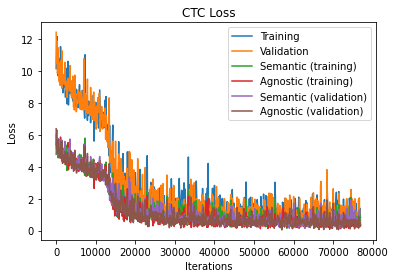

In [22]:
iterations = [100*x for x in range(len(ctc_train))]

plt.plot(iterations, ctc_train, label='Training')
plt.plot(iterations, ctc_eval, label='Validation')
plt.plot(iterations, ctc_train_sem, label='Semantic (training)')
plt.plot(iterations, ctc_train_agn, label='Agnostic (training)')
plt.plot(iterations, ctc_eval_sem, label='Semantic (validation)')
plt.plot(iterations, ctc_eval_agn, label='Agnostic (validation)')

plt.title('CTC Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
def test(model, dataloader):
    with torch.no_grad():
        seq_err = 0
        
        seq_err_sem = 0
        seq_err_agn = 0
        
        symbol_err_sem = 0
        symbol_err_agn = 0
        
        symbol_pct_err_sem = 0
        symbol_pct_err_agn = 0

        total_length_sem = 0
        total_length_agn = 0

        for _ in range(dataloader.test_iterations):
            test_batch, test_labels_sem, test_label_lengths_sem, test_labels_agn, test_label_lengths_agn = dataloader.next_batch("test")

            test_preds_sem, test_preds_agn = model(test_batch)
            test_preds_sem = test_preds_sem.log_softmax(2).argmax(2)
            test_preds_agn = test_preds_agn.log_softmax(2).argmax(2)
            del test_batch

            test_labels_sem = tensor_to_np_array(test_labels_sem)
            test_label_lengths_sem = tensor_to_np_array(test_label_lengths_sem)
            test_preds_sem = tensor_to_np_array(test_preds_sem).transpose(1,0)
            
            test_labels_agn = tensor_to_np_array(test_labels_agn)
            test_label_lengths_agn = tensor_to_np_array(test_label_lengths_agn)
            test_preds_agn = tensor_to_np_array(test_preds_agn).transpose(1,0)

            curr_idx_sem = 0
            curr_idx_agn = 0
            for i in range(dataloader.batch_size):
                length_sem = test_label_lengths_sem[i]
                length_agn = test_label_lengths_agn[i]
                
                pred_sem = test_preds_sem[i]
                label_sem = test_labels_sem[curr_idx_sem:curr_idx_sem+length_sem]
                pred_agn = test_preds_agn[i]
                label_agn = test_labels_agn[curr_idx_agn:curr_idx_agn+length_agn]
                
                pred_sem = np_to_string(pred_sem, int2word_sem, vocab_size_sem)
                label_sem = [int2word_sem[x] for x in label_sem]
                pred_agn = np_to_string(pred_agn, int2word_agn, vocab_size_agn)
                label_agn = [int2word_agn[x] for x in label_agn]

                err_sem = levenshtein(pred_sem, label_sem)
                if err_sem > 0:
                    seq_err_sem += 1

                err_agn = levenshtein(pred_agn, label_agn)
                if err_agn > 0:
                    seq_err_agn += 1
                    
                if err_sem > 0 or err_agn > 0:
                    seq_err += 1

                symbol_err_sem += err_sem
                symbol_pct_err_sem += sequence_levenshtein(pred_sem, label_sem)
                symbol_err_agn += err_agn
                symbol_pct_err_agn += sequence_levenshtein(pred_agn, label_agn)

                curr_idx_sem += length_sem
                total_length_sem += length_sem
                curr_idx_agn += length_agn
                total_length_agn += length_agn


            del test_labels_sem
            del test_preds_sem
            del test_label_lengths_sem
            del test_labels_agn
            del test_preds_agn
            del test_label_lengths_agn
            
            #print(seq_err, seq_err_sem, seq_err_agn)

        seq_err /= dataloader.test_iterations * dataloader.batch_size
        seq_err_sem /= dataloader.test_iterations * dataloader.batch_size
        seq_err_agn /= dataloader.test_iterations * dataloader.batch_size
        symbol_err_sem /= total_length_sem
        symbol_pct_err_sem /= total_length_sem
        symbol_err_agn /= total_length_agn
        symbol_pct_err_agn /= total_length_agn
        
        del total_length_sem
        del total_length_agn

        return(seq_err, seq_err_sem, seq_err_agn, symbol_err_sem, symbol_pct_err_sem, symbol_err_agn, symbol_pct_err_agn)

In [24]:
test(model, primus)

(0.926094890510949,
 0.848882299270073,
 0.7980155109489051,
 0.15007890608983374,
 0.002974041510185798,
 0.13321680063774663,
 0.00296566322449369)

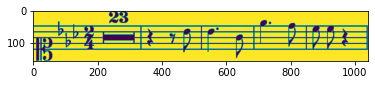

In [19]:
test_img = cv2.imread("Data/Example/000051652-1_2_1.png",False)
plt.imshow(test_img)

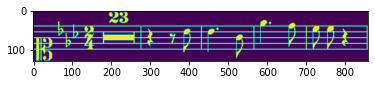

In [20]:
test_img = resize(test_img, 128)
test_img = normalize(test_img)
plt.imshow(test_img)

In [21]:
test_img = test_img.reshape((1,1,128,-1))
test_img.shape

(1, 1, 128, 859)

In [40]:
test_torch = torch.tensor(test_img, dtype=torch.float32).to(device)

pred_sem, pred_agn = model(test_torch)
pred_sem = pred_sem.log_softmax(2)
pred_agn = pred_agn.log_softmax(2)

pred_sem.size(), pred_agn.size()

(torch.Size([424, 1, 1782]), torch.Size([424, 1, 759]))

In [43]:
pred_sem = tensor_to_np_array(pred_sem)
pred_agn = tensor_to_np_array(pred_agn)

pred_sem, pred_agn

(array([   1,  229, 1751,  262, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781, 1781,
        1781, 1781, 1781, 1781, 1781, 

In [46]:
sample_gt_file_sem = open('Data/Example/000051652-1_2_1.semantic', 'r')
test_label_sem = sample_gt_file_sem.readline().rstrip().split('\t')
sample_gt_file_sem.close()

test_label_sem

['clef-C1',
 'keySignature-EbM',
 'timeSignature-2/4',
 'multirest-23',
 'barline',
 'rest-quarter',
 'rest-eighth',
 'note-Bb4_eighth',
 'barline',
 'note-Bb4_quarter.',
 'note-G4_eighth',
 'barline',
 'note-Eb5_quarter.',
 'note-D5_eighth',
 'barline',
 'note-C5_eighth',
 'note-C5_eighth',
 'rest-quarter',
 'barline']

In [49]:
pred_sem_str = log_softmax_to_string(pred_sem, int2word_sem, vocab_size_sem)
pred_sem_str

['clef-C1',
 'keySignature-EbM',
 'timeSignature-2/4',
 'multirest-21',
 'barline',
 'rest-quarter',
 'rest-eighth',
 'note-Bb4_eighth',
 'barline',
 'note-Bb4_quarter.',
 'note-G4_eighth',
 'barline',
 'note-Eb5_quarter.',
 'note-D5_eighth',
 'barline',
 'note-C5_eighth',
 'note-C5_eighth',
 'rest-quarter',
 'barline']

In [54]:
levenshtein(pred_sem_str, test_label_sem)

1

In [55]:
sequence_levenshtein(pred_sem_str, test_label_sem)

0.0043859649122807015

In [56]:
sample_gt_file_agn = open('Data/Example/000051652-1_2_1.agnostic', 'r')
test_label_agn = sample_gt_file_agn.readline().rstrip().split('\t')
sample_gt_file_agn.close()

test_label_agn

['clef.C-L1',
 'accidental.flat-L4',
 'accidental.flat-L2',
 'accidental.flat-S3',
 'digit.2-L4',
 'digit.4-L2',
 'digit.2-S5',
 'digit.3-S5',
 'multirest-L3',
 'barline-L1',
 'rest.quarter-L3',
 'rest.eighth-L3',
 'note.eighth-L4',
 'barline-L1',
 'note.quarter-L4',
 'dot-S4',
 'note.eighth-L3',
 'barline-L1',
 'note.quarter-S5',
 'dot-S5',
 'note.eighth-L5',
 'barline-L1',
 'note.eighth-S4',
 'note.eighth-S4',
 'rest.quarter-L3',
 'barline-L1']

In [57]:
pred_agn_str = log_softmax_to_string(pred_agn, int2word_agn, vocab_size_agn)
pred_agn_str

['clef.C-L1',
 'accidental.flat-L4',
 'accidental.flat-L2',
 'accidental.flat-S3',
 'digit.2-L4',
 'digit.4-L2',
 'digit.2-S5',
 'digit.3-S5',
 'multirest-L3',
 'barline-L1',
 'rest.quarter-L3',
 'rest.eighth-L3',
 'note.eighth-L4',
 'barline-L1',
 'note.quarter-L4',
 'dot-S4',
 'note.eighth-L3',
 'barline-L1',
 'note.quarter-S5',
 'dot-S5',
 'note.eighth-L5',
 'barline-L1',
 'note.eighth-S4',
 'note.eighth-S4',
 'rest.quarter-L3',
 'barline-L1']

In [58]:
levenshtein(pred_agn_str, test_label_agn)

0

In [59]:
sequence_levenshtein(pred_agn_str, test_label_agn)

0.0